Dataset Loaded: (300, 1024) Labels: (300,)
K=1: L1=0.3200, L2=0.3667
K=3: L1=0.3033, L2=0.3867
K=5: L1=0.3167, L2=0.3833
K=7: L1=0.3000, L2=0.4133
K=9: L1=0.3000, L2=0.4167
K=11: L1=0.3067, L2=0.4333


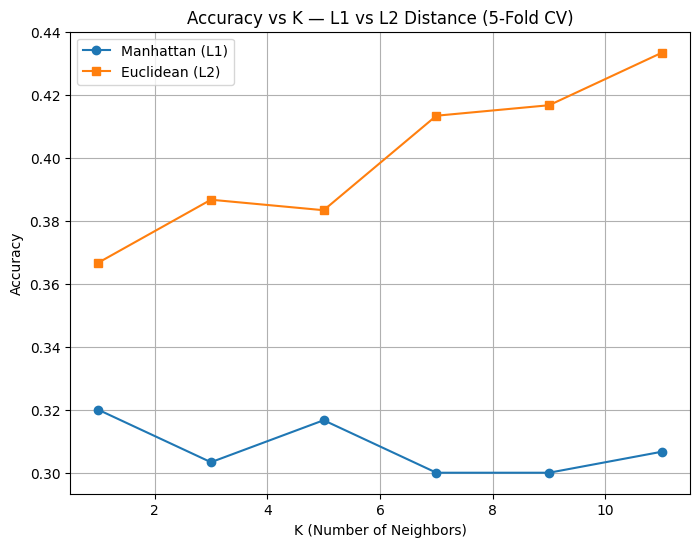


Top 5 Predictions for Random Images:

True Label: dog
Top-5 Predictions (distance, class):
dog (dist=0.00)
panda (dist=315.21)
panda (dist=317.95)
dog (dist=318.87)
cat (dist=319.32)


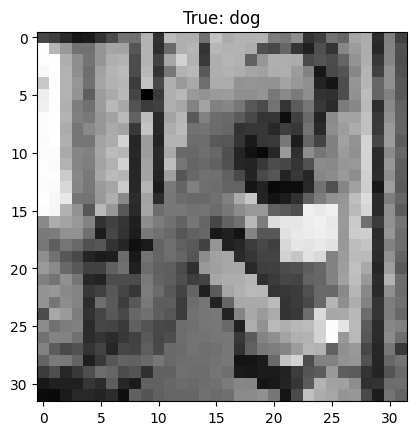


True Label: panda
Top-5 Predictions (distance, class):
panda (dist=0.00)
cat (dist=312.33)
cat (dist=313.93)
cat (dist=313.96)
dog (dist=314.42)


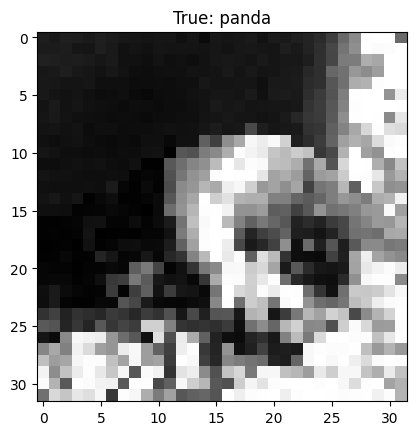


True Label: dog
Top-5 Predictions (distance, class):
dog (dist=0.00)
cat (dist=309.40)
dog (dist=312.59)
cat (dist=312.68)
dog (dist=314.99)


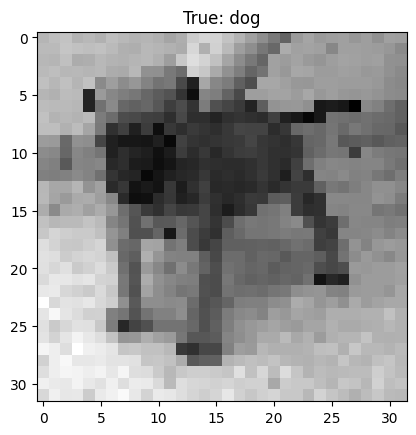


True Label: panda
Top-5 Predictions (distance, class):
panda (dist=0.00)
cat (dist=317.35)
cat (dist=318.09)
cat (dist=318.18)
panda (dist=319.01)


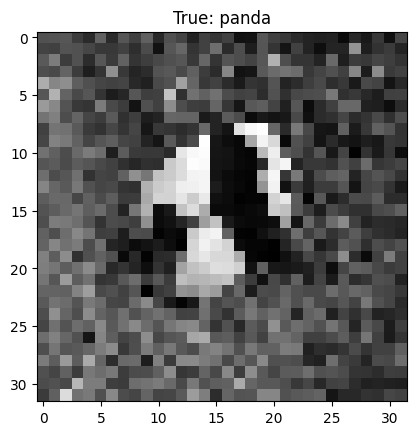


True Label: panda
Top-5 Predictions (distance, class):
panda (dist=0.00)
dog (dist=310.41)
cat (dist=310.98)
dog (dist=312.21)
cat (dist=314.69)


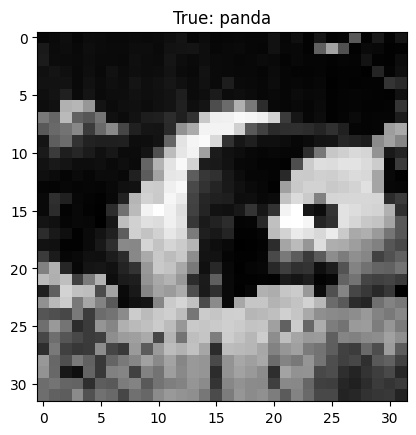

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from collections import Counter

# -------------------------------------------------------
# 1. Load Images and Convert to 32x32 Grayscale
# -------------------------------------------------------

DATASET_PATH = "animal_dataset"   # cat / dog / panda folders
CLASSES = ["cat", "dog", "panda"]

X = []  # images
y = []  # labels

for label_idx, class_name in enumerate(CLASSES):
    folder = os.path.join(DATASET_PATH, class_name)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)

        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (32, 32))

        X.append(img.flatten())
        y.append(label_idx)

X = np.array(X)
y = np.array(y)

print("Dataset Loaded:", X.shape, "Labels:", y.shape)


# -------------------------------------------------------
# 2. Distance Functions (L1 and L2)
# -------------------------------------------------------

def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


# -------------------------------------------------------
# 3. kNN Classifier (from scratch)
# -------------------------------------------------------

def knn_predict(X_train, y_train, x_test, k, distance_type="L2"):
    distances = []

    for i in range(len(X_train)):
        if distance_type == "L1":
            d = manhattan_distance(X_train[i], x_test)
        else:
            d = euclidean_distance(X_train[i], x_test)
        distances.append((d, y_train[i]))

    distances.sort(key=lambda x: x[0])
    k_nearest = distances[:k]
    labels = [label for _, label in k_nearest]

    most_common = Counter(labels).most_common(1)[0][0]
    return most_common


# -------------------------------------------------------
# 4. 5-Fold Cross Validation
# -------------------------------------------------------

kf = KFold(n_splits=5, shuffle=True, random_state=42)

K_values = [1, 3, 5, 7, 9, 11]
acc_l1 = []
acc_l2 = []

for K in K_values:
    fold_acc_l1 = []
    fold_acc_l2 = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # predictions for this fold
        preds_L1 = []
        preds_L2 = []

        for i in range(len(X_val)):
            preds_L1.append(knn_predict(X_train, y_train, X_val[i], K, distance_type="L1"))
            preds_L2.append(knn_predict(X_train, y_train, X_val[i], K, distance_type="L2"))

        acc_l1_fold = np.mean(np.array(preds_L1) == y_val)
        acc_l2_fold = np.mean(np.array(preds_L2) == y_val)

        fold_acc_l1.append(acc_l1_fold)
        fold_acc_l2.append(acc_l2_fold)

    acc_l1.append(np.mean(fold_acc_l1))
    acc_l2.append(np.mean(fold_acc_l2))

    print(f"K={K}: L1={acc_l1[-1]:.4f}, L2={acc_l2[-1]:.4f}")


# -------------------------------------------------------
# 5. Plot Accuracy vs K (L1 vs L2)
# -------------------------------------------------------

plt.figure(figsize=(8, 6))
plt.plot(K_values, acc_l1, marker='o', label="Manhattan (L1)")
plt.plot(K_values, acc_l2, marker='s', label="Euclidean (L2)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K — L1 vs L2 Distance (5-Fold CV)")
plt.grid(True)
plt.legend()
plt.show()


# -------------------------------------------------------
# 6. Show Top-5 Predictions
# -------------------------------------------------------

def knn_top5(X_train, y_train, x_test, distance_type="L2"):
    distances = []

    for i in range(len(X_train)):
        if distance_type == "L1":
            d = manhattan_distance(X_train[i], x_test)
        else:
            d = euclidean_distance(X_train[i], x_test)

        distances.append((d, y_train[i]))

    distances.sort(key=lambda x: x[0])
    top5 = distances[:5]

    return [(d, CLASSES[label]) for (d, label) in top5]


# pick 5 random test images
print("\nTop 5 Predictions for Random Images:")
for i in np.random.choice(len(X), 5, replace=False):
    img = X[i].reshape(32, 32)
    true_label = CLASSES[y[i]]

    top5 = knn_top5(X, y, X[i], distance_type="L2")

    print("\nTrue Label:", true_label)
    print("Top-5 Predictions (distance, class):")
    for d, c in top5:
        print(f"{c} (dist={d:.2f})")

    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}")
    plt.show()
